## Music Recommendation System Using Machine Learning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

In [2]:
tracks = pd.read_csv("SpotifyAudioFeaturesApril2019.csv")
tracks.head()

,artist_name,track_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
0,YG,2RM4jf1Xa9zPgMGRDiht8O,"Big Bank feat. 2 Chainz, Big Sean, Nicki Minaj",0.005820,0.743,238373,0.339,0.000,1,0.0812,-7.678,1,0.4090,203.927,4,0.118,15
1,YG,1tHDG53xJNGsItRA3vfVgs,BAND DRUM (feat. A$AP Rocky),0.024400,0.846,214800,0.557,0.000,8,0.2860,-7.259,1,0.4570,159.009,4,0.371,0
2,R3HAB,6Wosx2euFPMT14UXiWudMy,Radio Silence,0.025000,0.603,138913,0.723,0.000,9,0.0824,-5.890,0,0.0454,114.966,4,0.382,56
3,Chris Cooq,3J2Jpw61sO7l6Hc7qdYV91,Lactose,0.029400,0.800,125381,0.579,0.912,5,0.0994,-12.118,0,0.0701,123.003,4,0.641,0
4,Chris Cooq,2jbYvQCyPgX3CdmAzeVeuS,Same - Original mix,0.000035,0.783,124016,0.792,0.878,7,0.0332,-10.277,1,0.0661,120.047,4,0.928,0


In [3]:
tracks.shape

(130663, 17)

In [4]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130663 entries, 0 to 130662
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   artist_name       130663 non-null  object 
 1   track_id          130663 non-null  object 
 2   track_name        130662 non-null  object 
 3   acousticness      130663 non-null  float64
 4   danceability      130663 non-null  float64
 5   duration_ms       130663 non-null  int64  
 6   energy            130663 non-null  float64
 7   instrumentalness  130663 non-null  float64
 8   key               130663 non-null  int64  
 9   liveness          130663 non-null  float64
 10  loudness          130663 non-null  float64
 11  mode              130663 non-null  int64  
 12  speechiness       130663 non-null  float64
 13  tempo             130663 non-null  float64
 14  time_signature    130663 non-null  int64  
 15  valence           130663 non-null  float64
 16  popularity        13

In [5]:
tracks.isnull().sum()

artist_name         0
track_id            0
track_name          1
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
popularity          0
dtype: int64

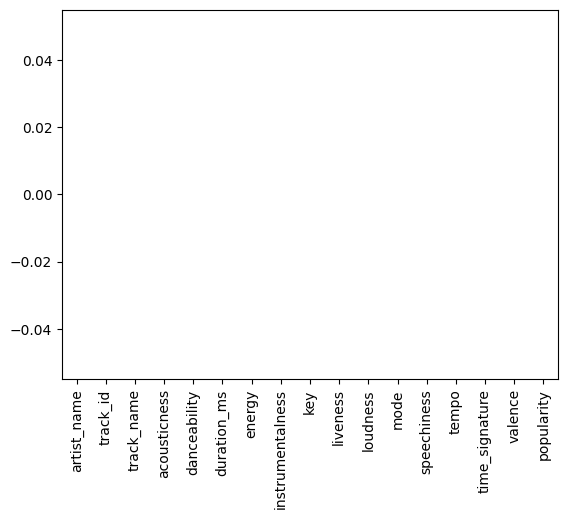

In [6]:
tracks.dropna(inplace=True)
tracks.isnull().sum().plot.bar()
plt.show()

In [7]:
tracks = tracks.drop(['track_id'], axis=1)

### Exploratory Data Analysis


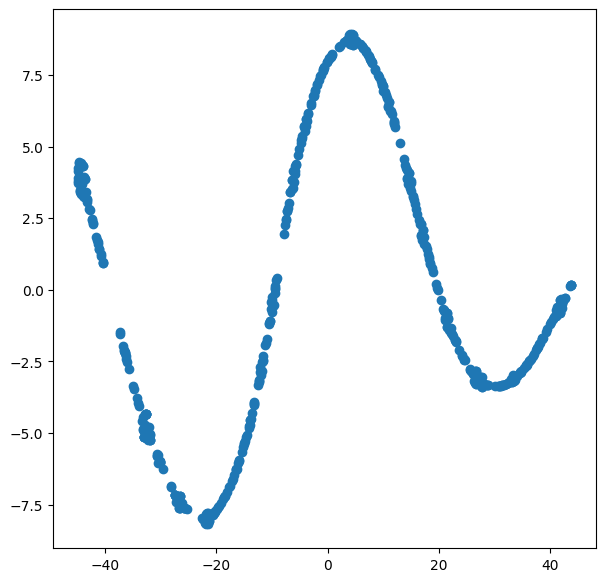

In [8]:
model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(tracks.head(500).drop(columns=['artist_name', 'track_name'], inplace=False))
plt.figure(figsize=(7, 7))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1])
plt.show()

In [9]:
tracks['track_name'].nunique(), tracks.shape

(108889, (130662, 16))

In [10]:
tracks = tracks.sort_values(by=['popularity'], ascending=False)
tracks.drop_duplicates(subset=['track_name'], keep='first', inplace=True)

In [11]:
floats = []
for col in tracks.columns:
    if tracks[col].dtype == 'float':
        floats.append(col)

print(floats, "\nLength of float column", len(floats))

['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence'] 
Length of float column 9


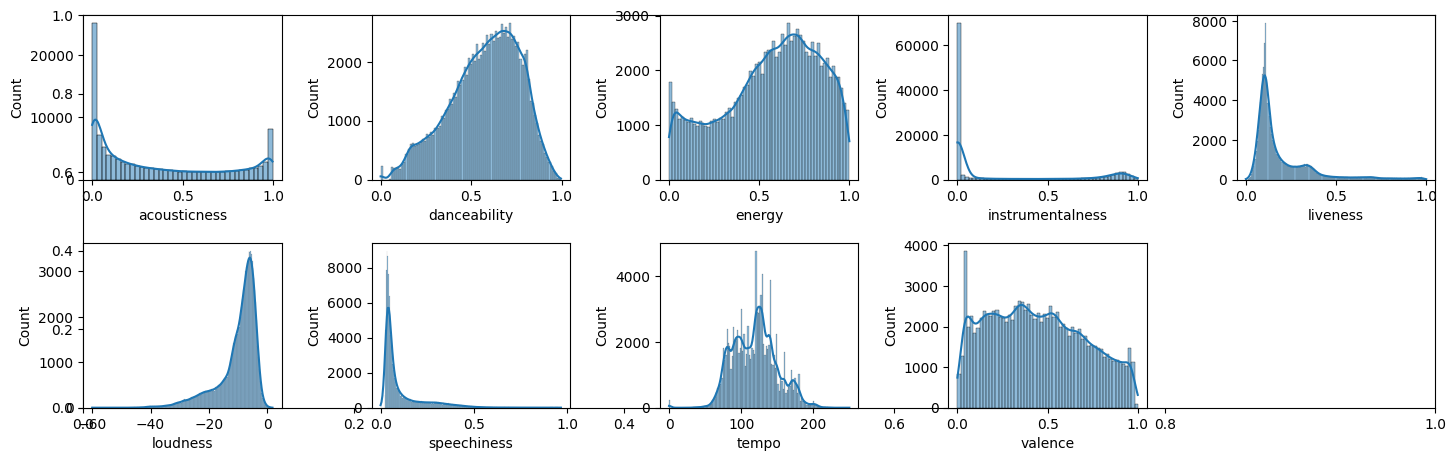

In [12]:
plt.subplots(figsize=(15, 5))
for i, col in enumerate(floats):
    plt.subplot(2, 5, i+1)
    sns.histplot(tracks[col], kde=True)
plt.tight_layout()
plt.show()

In [13]:
%%capture
song_vectorizer = CountVectorizer()
song_vectorizer.fit(tracks['track_name'])

In [14]:
tracks = tracks.sort_values(by=['popularity'], ascending=False).head(10000)

In [15]:
def get_similarity(song_name, data):
    # Getting vector for the input song
    text_array1 = song_vectorizer.transform(data[data['track_name']==song_name]['track_name']).toarray()
    num_array1 = data[data['track_name']==song_name].select_dtypes(include=np.number).to_numpy()

    # We will store similarity for each row of the dataset
    sim = []
    for idx, row in data.iterrows():
        name = row['track_name']

        # Getting vector for current song
        text_array2 = song_vectorizer.transform(data[data['track_name']==name]['track_name']).toarray()
        num_array2 = data[data['track_name']==name].select_dtypes(include=np.number).to_numpy()

        # Calculating similarities for text as well as numeric features
        text_sim = cosine_similarity(text_array1, text_array2)[0][0]
        num_sim = cosine_similarity(num_array1, num_array2)[0][0]
        sim.append(text_sim + num_sim)

    return sim

In [16]:
def recommend_songs(song_name, data=tracks):
    # Base case
    if tracks[tracks['track_name'] == song_name].shape[0] == 0:
        print('This song is either not so popular or you\
        have entered invalid_name.\n Some songs you may like:\n')
        
        for song in data.sample(n=5)['track_name'].values:
            print(song)
        return

    data['similarity_factor'] = get_similarity(song_name, data)

    data.sort_values(by=['similarity_factor', 'popularity'],
                    ascending = [False, False],
                    inplace=True)

    # First song will be the input song itself as the similarity will be highest.
    display(data[['track_name', 'artist_name']][2:7])


In [17]:
recommend_songs('Shape of You')

This song is either not so popular or you        have entered invalid_name.
 Some songs you may like:

Nada Nuevo
Batshit
Beyond Barricades
Como Antes
Dame Tu Cosita (feat. Cutty Ranks)


In [19]:
recommend_songs('Love Someone')

,track_name,artist_name
128598,Love U,CHUNG HA
130139,LOVE,Gianluca Vacchi
125226,Love,Imagine Dragons
96267,Love Someone - Piano Demo,Lukas Graham
126420,For the Love of Love,Novo Talos


In [20]:
recommend_songs('Love me like you do')

This song is either not so popular or you        have entered invalid_name.
 Some songs you may like:

Sinnò Me Moro
Currency
Streatham
The Nights
The Otha Side


---